# [EDA] Heatmap & Grid-scatters
可以有效的將表格型的圖進行視覺化, 常見的 Heatmap
* 相關圖
* Confusion matrix (混淆矩陣)


In [1]:
# Import 需要的套件
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # 另一個繪圖-樣式套件
plt.style.use('ggplot')

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# 設定 data_path
dir_data = './data/'

In [2]:
f_app = os.path.join(dir_data, 'application_train.csv')
print('Path of read in data: %s' % (f_app))
app_train = pd.read_csv(f_app)
app_train.head()

Path of read in data: ./data/application_train.csv


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
# 取出 EXT_SOURCE 的幾項變數並檢驗其相關性
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.155317,-0.160472,-0.178919,-0.078239
EXT_SOURCE_1,-0.155317,1.000000,0.213982,0.186846,0.600610
EXT_SOURCE_2,-0.160472,0.213982,1.000000,0.109167,0.091996
EXT_SOURCE_3,-0.178919,0.186846,0.109167,1.000000,0.205478
DAYS_BIRTH,-0.078239,0.600610,0.091996,0.205478,1.000000


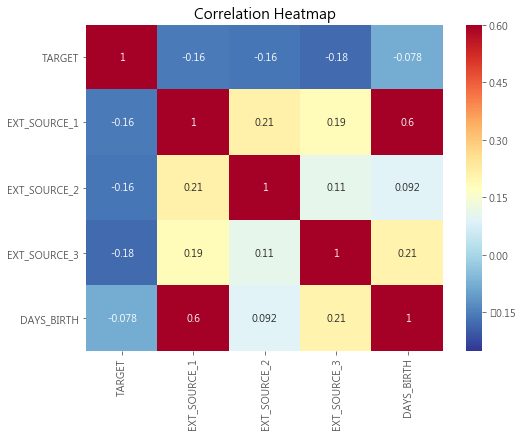

In [4]:
plt.figure(figsize = (8, 6))
# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

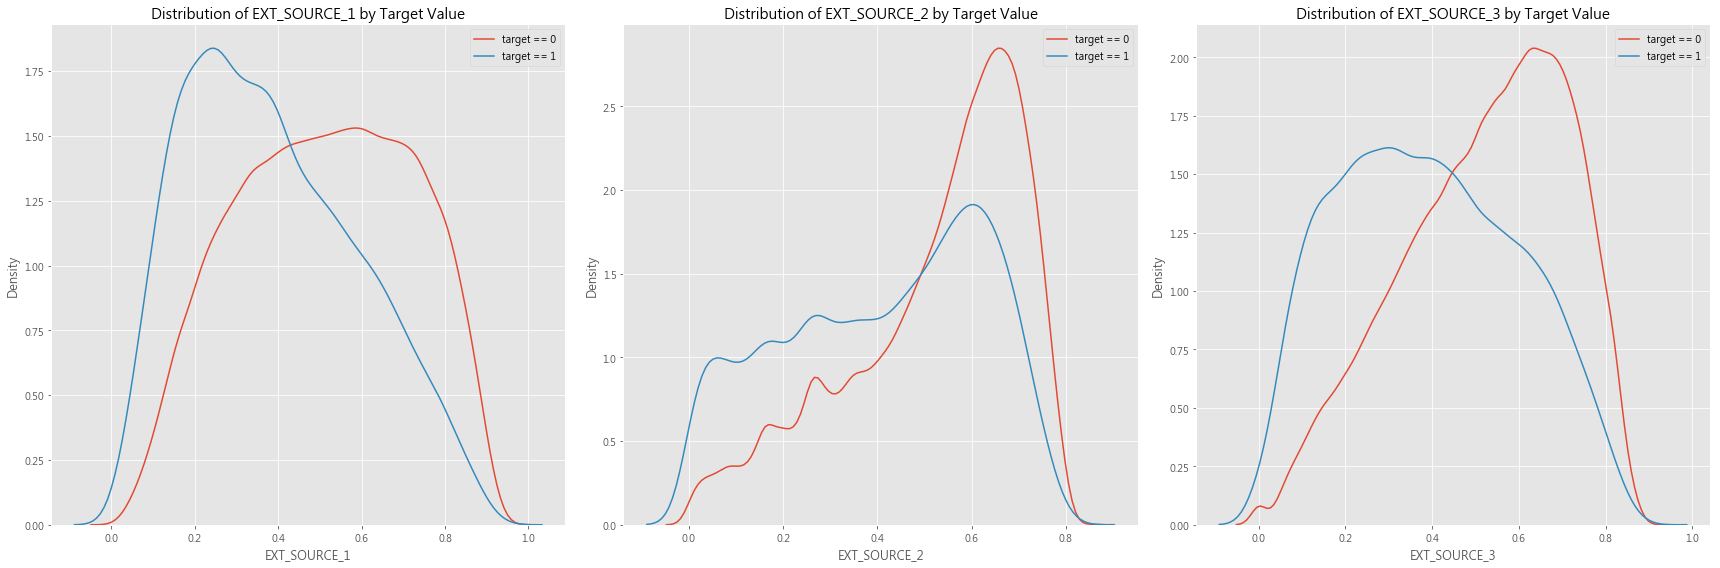

In [5]:
# 進一步我們檢查這三項變數在 Target 上的分布是否不同
plt.figure(figsize = (24, 8))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    # 做 subplot
    plt.subplot(1, 3, i + 1)
    
    # KDE
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, source], label = 'target == 0')
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, source], label = 'target == 1')
    
    # Label it!
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

In [6]:
# 轉成以年記齡後，將以日記齡丟掉
plot_data = ext_data.copy()
plot_data['YEARS_BIRTH'] = plot_data['DAYS_BIRTH'] / 365
plot_data.drop(['DAYS_BIRTH'],axis = 1, inplace=True)

# Function to calculate correlation coefficient between two columns
def corr_func(x, y, **kwargs):
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.2, .8), xycoords=ax.transAxes,
                size = 20)

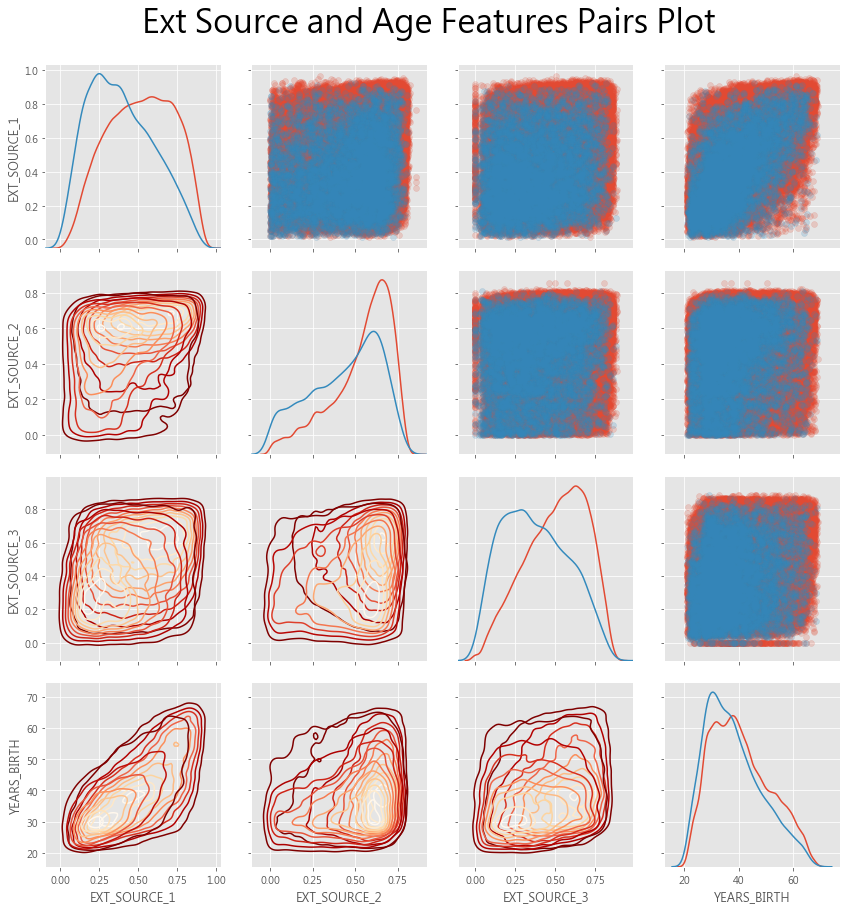

In [7]:
N_sample = 100000
# Drop na values and limit to 100000 data: 因為要畫點圖, 如果點太多，會畫很久!
plot_data = plot_data.dropna().sample(n = N_sample)
# Create the pairgrid object
grid = sns.PairGrid(data = plot_data, size = 3, diag_sharey=False,
                    hue = 'TARGET', 
                    vars = [x for x in list(plot_data.columns) if x != 'TARGET'])

# 上半部為 scatter
grid.map_upper(plt.scatter, alpha = 0.2)

# 對角線畫 histogram
grid.map_diag(sns.kdeplot)

# 下半部放 density plot
grid.map_lower(sns.kdeplot, cmap = plt.cm.OrRd_r)

plt.suptitle('Ext Source and Age Features Pairs Plot', size = 32, y = 1.05)
plt.show()

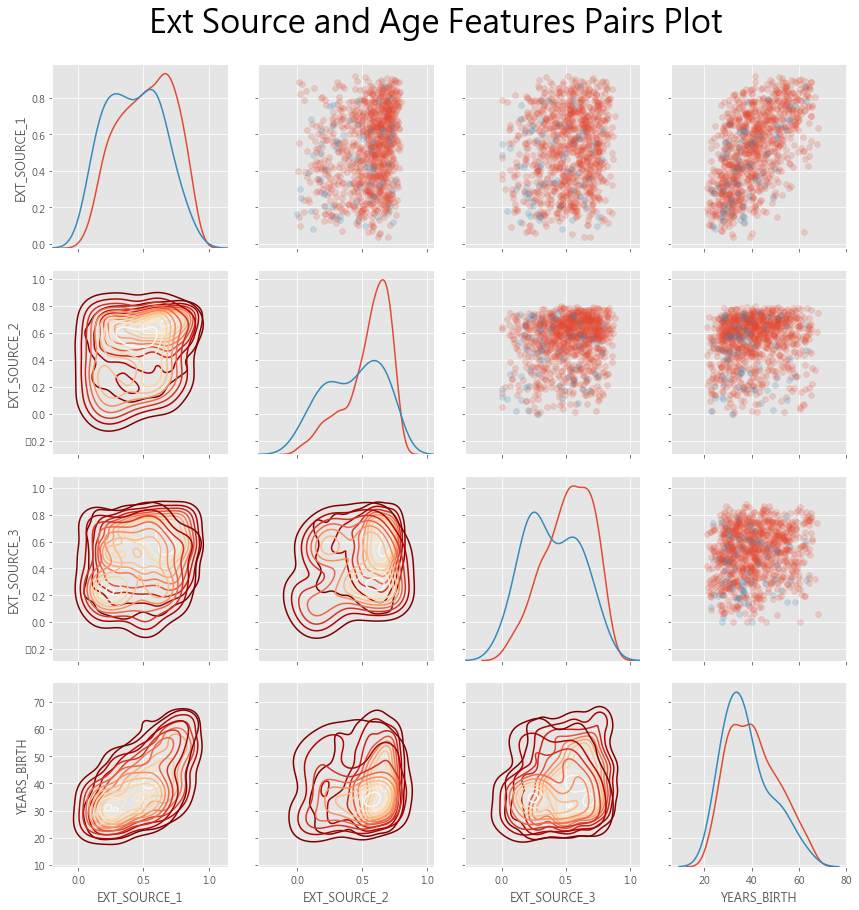

In [8]:
# 試著以不同 size 畫看看，觀察有那裡不太一樣
N_sample = 1000

plot_data = plot_data.dropna().sample(n = N_sample)
# Create the pairgrid object
grid = sns.PairGrid(data = plot_data, size = 3, diag_sharey=False,
                    hue = 'TARGET', 
                    vars = [x for x in list(plot_data.columns) if x != 'TARGET'])

# 上半部為 scatter
grid.map_upper(plt.scatter, alpha = 0.2)

# 對角線畫 histogram
grid.map_diag(sns.kdeplot)

# 下半部放 density plot
grid.map_lower(sns.kdeplot, cmap = plt.cm.OrRd_r)

plt.suptitle('Ext Source and Age Features Pairs Plot', size = 32, y = 1.05)
plt.show()

## 作業
1. 請用 numpy 建立一個 10 x 10, 數值分布自 -1.0 ~ 1.0 的矩陣並繪製 Heatmap
2. 請用 numpy 建立一個 1000 x 3, 數值分布為 -1.0 ~ 1.0 的矩陣，並繪製 PairPlot (上半部為 scatter, 對角線為 hist, 下半部為 density)
3. 請用 numpy 建立一個 1000 x 3, 數值分布為常態分佈的矩陣，並繪製 PairPlot (上半部為 scatter, 對角線為 hist, 下半部為 density)